In [1]:
import collections
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline

In [2]:
# Sample sentences
sentences = ["the quick brown fox jumped over the lazy dog",
            "I love cats and dogs",
            "we all love cats and dogs",
            "cats and dogs are great",
            "sung likes cats",
            "she loves dogs",
            "cats can be very independent",
            "cats are great companions when they want to be",
            "cats are playful",
            "cats are natural hunters",
            "It's raining cats and dogs",
            "dogs and cats love sung"]

# sentences to words and count
words=" ".join(sentences).split()  # [the,quick,brown,....]
count= collections.Counter(words).most_common() #('cats', 10)
print ("Word count", count[:5])

Word count [('cats', 10), ('dogs', 6), ('and', 5), ('are', 4), ('love', 3)]


In [3]:
# Build dictionaries
unique_words =  [i[0] for i in count]

In [4]:
dic = {w: i for i, w in enumerate(unique_words)} #dic, word -> id cats:0 dogs:1 ......
voc_size = len(dic)


In [5]:
# Make indexed word data
data = [dic[word] for word in words] #count rank for every word in words
print('Sample data', data[:10], words[:10])

Sample data [5, 9, 10, 11, 12, 13, 5, 14, 15, 16] ['the', 'quick', 'brown', 'fox', 'jumped', 'over', 'the', 'lazy', 'dog', 'I']


In [6]:
# Let's make a training data for window size 1 for simplicity
# ([the, brown], quick), ([quick, fox], brown), ([brown, jumped], fox), ...
cbow_pairs = [];
for i in range(1, len(data)-1) :
    cbow_pairs.append([[data[i-1], data[i+1]], data[i]]);
print('Context pairs rank ids', cbow_pairs[:5])
print()
cbow_pairs_words = [];
for i in range(1, len(words)-1) :
    cbow_pairs_words.append([[words[i-1], words[i+1]], words[i]]);
print('Context pairs words', cbow_pairs_words[:5])

Context pairs rank ids [[[5, 10], 9], [[9, 11], 10], [[10, 12], 11], [[11, 13], 12], [[12, 5], 13]]

Context pairs words [[['the', 'brown'], 'quick'], [['quick', 'fox'], 'brown'], [['brown', 'jumped'], 'fox'], [['fox', 'over'], 'jumped'], [['jumped', 'the'], 'over']]


In [7]:
# Let's make skip-gram pairs
# (quick, the), (quick, brown), (brown, quick), (brown, fox), ...
skip_gram_pairs=[]

for c in cbow_pairs:
    skip_gram_pairs.append([c[1],c[0][0]])
    skip_gram_pairs.append([c[1],c[0][1]])
print('skip-gram pairs', skip_gram_pairs[:5])
print()
skip_gram_pairs_words=[]
for c in cbow_pairs_words:
    skip_gram_pairs_words.append([c[1],c[0][0]])
    skip_gram_pairs_words.append([c[1],c[0][1]])
print('skip-gram pairs words', skip_gram_pairs_words[:5])

                            

skip-gram pairs [[9, 5], [9, 10], [10, 9], [10, 11], [11, 10]]

skip-gram pairs words [['quick', 'the'], ['quick', 'brown'], ['brown', 'quick'], ['brown', 'fox'], ['fox', 'brown']]


In [8]:
def get_batch(size):
    assert size<len(skip_gram_pairs)
    X=[]
    Y=[]
    rdm = np.random.choice(range(len(skip_gram_pairs)),size,replace=False)
    
    for r in rdm:
        X.append(skip_gram_pairs[r][0])
        Y.append([skip_gram_pairs[r][1]])
    return X , Y

# generate_batch test
print ('Batches (x, y)', get_batch(3))

Batches (x, y) ([2, 12, 15], [[1], [13], [14]])


In [9]:
#tensor flow code

batch_size = 20
embedding_size = 2
num_sampled = 15    # Number of negative examples to sample.

X= tf.placeholder(tf.int32,shape=[batch_size]) #inputs
Y= tf.placeholder(tf.int32,shape=[batch_size,1]) #labels

with tf.device("/cpu:0"):
      # Look up embeddings for inputs.
    embeddings = tf.Variable(tf.random_uniform([voc_size,embedding_size],-1.0,1.0))
    embed = tf.nn.embedding_lookup(embeddings, X) # lookup table
    
# Construct the variables for the NCE loss
nce_weights = tf.Variable(tf.random_uniform([voc_size, embedding_size],-1.0, 1.0))
nce_biases = tf.Variable(tf.zeros([voc_size]))

# Compute the average NCE loss for the batch.
# This does the magic:
#   tf.nn.nce_loss(weights, biases, inputs, labels, num_sampled, num_classes ...)
# It automatically draws negative samples when we evaluate the loss.
loss = tf.reduce_mean(tf.nn.nce_loss(nce_weights, nce_biases, Y, embed, num_sampled, voc_size))
# Use the adam optimizer
optimizer = tf.train.AdamOptimizer(1e-1).minimize(loss)

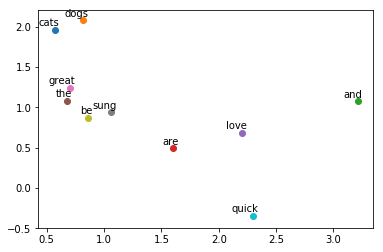

In [10]:
epochs=100
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for epoch in range(epochs):
        
        batch_inputs, batch_labels = get_batch(batch_size)
        _,loss_val=sess.run([optimizer,loss],feed_dict = {X : batch_inputs, Y : batch_labels })
        
        #if epoch % 10 == 0:
          #print("Loss at ", epoch, loss_val) # Report the loss
    
    # Final embeddings are ready for you to use. Need to normalize for practical use
    trained_embeddings = embeddings.eval()
    
    
# Show word2vec if dim is 2
if trained_embeddings.shape[1] == 2:
    labels = unique_words[:10] # Show top 10 words
    for i, label in enumerate(labels):
        x, y = trained_embeddings[i,:]
        plt.scatter(x, y)
        plt.annotate(label, xy=(x, y), xytext=(5, 2),
            textcoords='offset points', ha='right', va='bottom')
    #plt.savefig("word2vec.png")